In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# define function for processing results for cumulative elevation
def process_results(results_filename):
    ds = xr.open_dataset(results_filename)
    dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
    ds = ds.rename_dims(dimensions_dict)
    year_data = ds.isel(cell=0).density.data
    ds = ds.assign_coords(year = ('time',year_data))
    ds = ds.isel(cell=slice(1,None))
    ds['cumulative_elevation']=ds.DIP[:,6]
    ds['FAC']=ds.DIP[:,1]
    return(ds)

In [3]:
experiment_path = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/'

results_ds = process_results(f'{experiment_path}results/CFMresults.hdf5')
nosublim_results_ds = process_results(f'{experiment_path}results/no_sublim/CFMresults.hdf5')

df_list = []
vars = ['BDOT','SMELT','SUBLIM']

for var in vars:
    df = pd.read_csv(f'{experiment_path}CFMinput_example/adjusted_{var}.csv')
    df_list.append(df)

times = df_list[0].T.index.values.astype('float')
timestep = times[1]-times[0]
smb = sum(df_list)*timestep

results_ds['SMB'] = (('time'), smb.values.ravel())
results_ds['SMB Spinup Average'] = results_ds['SMB'].where(results_ds['year']<1980,drop=True).mean()
results_ds['SMB Difference to Spinup Average'] = results_ds['SMB']-results_ds['SMB Spinup Average']
results_ds['dFAC']=results_ds['FAC'].copy()
results_ds['dFAC'][2:]=results_ds['FAC'][2:]-results_ds['FAC'][1:-1]
results_ds['dFAC'][:2]=np.nan
results_ds['ele change calc'] = results_ds['SMB Difference to Spinup Average']+results_ds['dFAC']
results_ds['cum ele change calc'] = results_ds['ele change calc'].cumsum()

results_ds['FAC Adj'] = results_ds['FAC'] - results_ds['FAC'][1]
nosublim_results_ds['FAC Adj'] = nosublim_results_ds['FAC'] - nosublim_results_ds['FAC'][1]

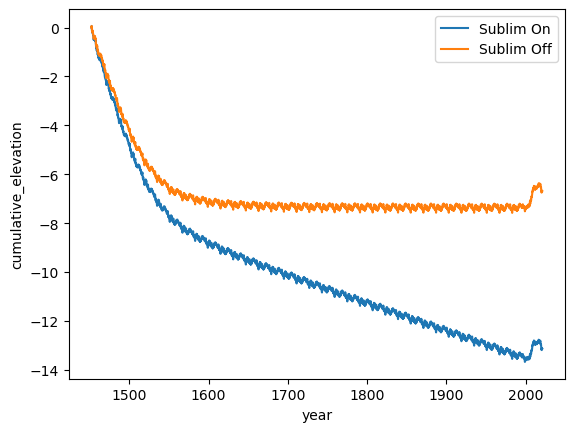

In [4]:
results_ds['cumulative_elevation'].plot.line(x='year',label='Sublim On')
nosublim_results_ds['cumulative_elevation'].plot.line(x='year',label='Sublim Off')
plt.legend()

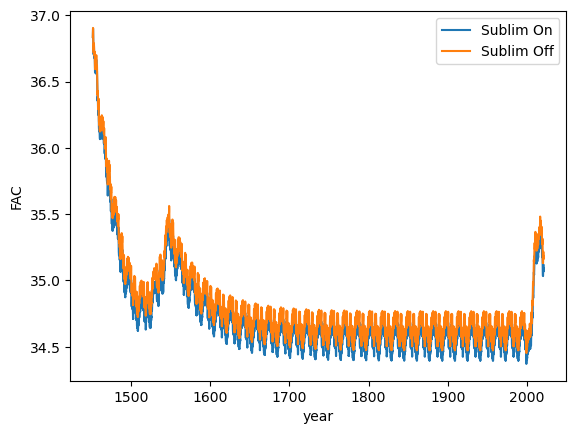

In [5]:
results_ds['FAC'][1:].plot.line(x='year',label='Sublim On')
nosublim_results_ds['FAC'][1:].plot.line(x='year',label='Sublim Off')
plt.legend()

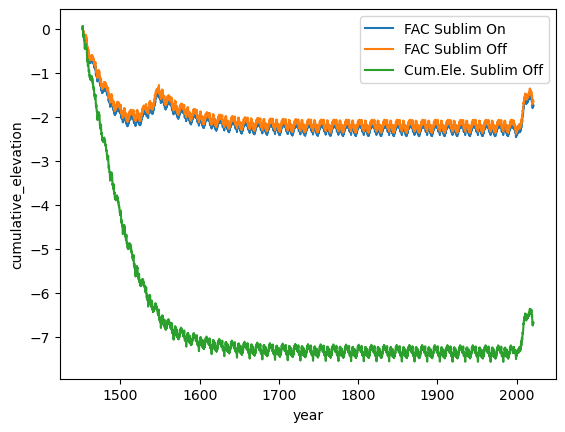

In [6]:
results_ds['FAC Adj'][1:].plot.line(x='year',label='FAC Sublim On')
nosublim_results_ds['FAC Adj'][1:].plot.line(x='year',label='FAC Sublim Off')
nosublim_results_ds['cumulative_elevation'].plot.line(x='year',label='Cum.Ele. Sublim Off')
plt.legend()

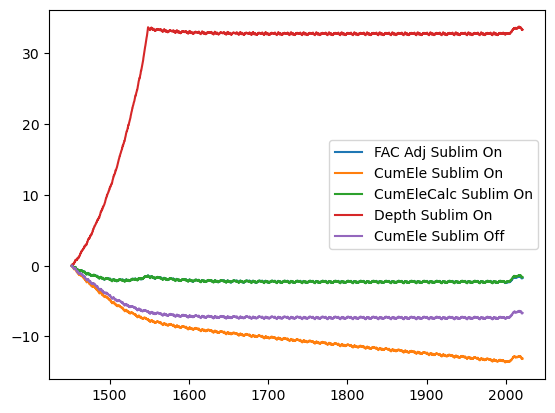

In [7]:
ds = results_ds.where(results_ds['year']>1450,drop=True)
ds_diff = ds-ds.isel(time=0)
x = ds.year

y = ds_diff['FAC Adj']
plt.plot(x,y,label='FAC Adj Sublim On')
y = ds_diff['cumulative_elevation']
plt.plot(x,y,label='CumEle Sublim On')
y = ds_diff['cum ele change calc']
plt.plot(x,y,label='CumEleCalc Sublim On')
y = ds_diff['depth'].isel(cell=-1)
plt.plot(x,y,label='Depth Sublim On')

ds = nosublim_results_ds.where(results_ds['year']>1450,drop=True)
ds_diff = ds-ds.isel(time=0)
y = ds_diff['cumulative_elevation']
plt.plot(x,y,label='CumEle Sublim Off')

plt.legend()

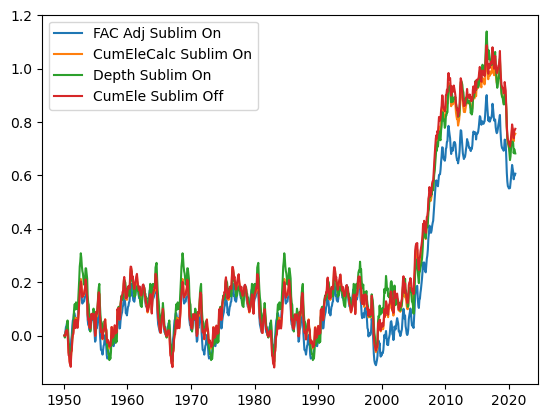

In [8]:
ds = results_ds.where(results_ds['year']>1950,drop=True)
ds_diff = ds-ds.isel(time=0)
x = ds.year

y = ds_diff['FAC Adj']
plt.plot(x,y,label='FAC Adj Sublim On')
# y = ds_diff['cumulative_elevation']
# plt.plot(x,y,label='CumEle Sublim On')
y = ds_diff['cum ele change calc']
plt.plot(x,y,label='CumEleCalc Sublim On')
y = ds_diff['depth'].isel(cell=-1)
plt.plot(x,y,label='Depth Sublim On')

ds = nosublim_results_ds.where(results_ds['year']>1950,drop=True)
ds_diff = ds-ds.isel(time=0)
y = ds_diff['cumulative_elevation']
plt.plot(x,y,label='CumEle Sublim Off')

plt.legend()

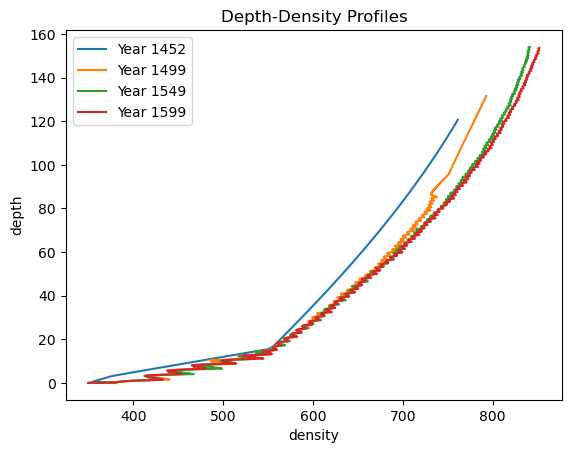

In [9]:
ds = results_ds.swap_dims({"time": "year"})

ds_ = ds.isel(year=1)
ds_ = ds_.swap_dims({"cell": "density"})
ds_['depth'].plot.line(x='density',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1500,method='nearest')
ds_ = ds_.swap_dims({"cell": "density"})
ds_['depth'].plot.line(x='density',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1550,method='nearest')
ds_ = ds_.swap_dims({"cell": "density"})
ds_['depth'].plot.line(x='density',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1600,method='nearest')
ds_ = ds_.swap_dims({"cell": "density"})
ds_['depth'].plot.line(x='density',label=f'Year {int(ds_.year.data)}')

plt.title('Depth-Density Profiles')
plt.legend()

In [10]:
results_ds['depth'][:,2:]

<xarray.DataArray 'depth' (time: 6828, cell: 1168)>
[7975104 values with dtype=float32]
Coordinates:
    year     (time) float32 1.452e+03 1.452e+03 ... 2.021e+03 2.021e+03
Dimensions without coordinates: time, cell

In [11]:
# ds.density*(ds.depth.isel(cell=-1)-ds.depth.isel(cell=-2))
results_ds['ddepth']=results_ds['depth'].copy()
results_ds['ddepth'][:,2:]=results_ds['depth'][:,2:]-results_ds['depth'][:,1:-1]
results_ds['ddepth'][:,:2]=np.nan
results_ds['mass'] = results_ds.density*results_ds.ddepth

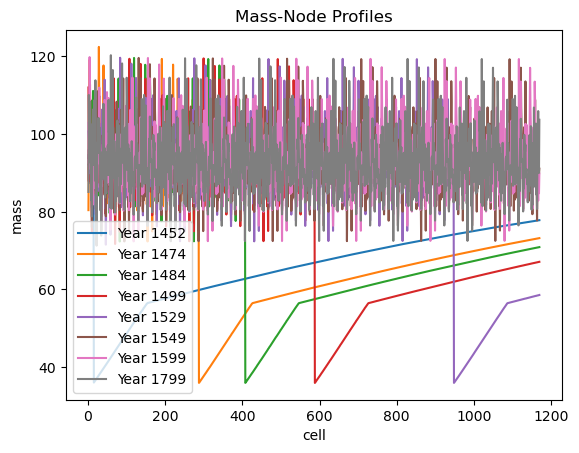

In [12]:
ds = results_ds.swap_dims({"time": "year"})

ds_ = ds.isel(year=3)
ds_['mass'].plot.line(x='cell',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1475,method='nearest')
ds_['mass'].plot.line(x='cell',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1485,method='nearest')
ds_['mass'].plot.line(x='cell',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1500,method='nearest')
ds_['mass'].plot.line(x='cell',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1530,method='nearest')
ds_['mass'].plot.line(x='cell',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1550,method='nearest')
ds_['mass'].plot.line(x='cell',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1600,method='nearest')
ds_['mass'].plot.line(x='cell',label=f'Year {int(ds_.year.data)}')

ds_ = ds.sel(year=1800,method='nearest')
ds_['mass'].plot.line(x='cell',label=f'Year {int(ds_.year.data)}')

plt.title('Mass-Node Profiles')
plt.legend()